# $k$-armed bandits

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## The $k$-armed testbed

In order to demonstrate the bandit-algorithms, let us create some test-data. Here, we have five actions $a=1,...,5$ and their mean rewards are $q_*(a)=5, 4, 8, 3, 7$. The actual rewards are drawn from a normal distribution with mean $q_*(a)$ and variance 1.

In [2]:
from bandit import Bandit
mean_rewards = [5, 4, 8, 3, 7]
testbed = [Bandit(mr) for mr in mean_rewards]

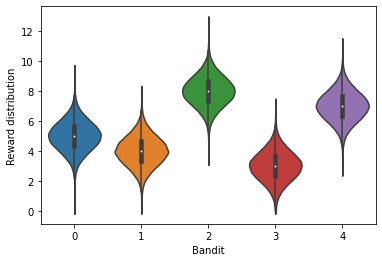

In [3]:
samples = [[bandit.pull() for _ in range(100000)] for bandit in testbed]

plt.figure()
sns.violinplot(data=samples)
plt.xlabel("Bandit")
plt.ylabel("Reward distribution");

## Implementation of a simple greedy algorithm

The bandits are implemented as classes with the following properties:
* mean of the underlying distribution $q$.
* number of previous samplings $n$.
* current estimate of reward $Q$.

The bandits have the following methods:
* init: in the simplest case, we initialize $Q=0$.
* pull: return a value $R$ from the underlying distribution
* update: update the current reward estimate: $Q_t = Q_{t-1} + \frac{1}{n} (R- Q_{t-1})$
* sample: returns the current reward estimate $Q$.

In every step of the bandit problem, we have to *choose an action*. Only for this action, we will receive a reward value.

This is different to other machine learning problems, as we do not receive information on the rewards that we would have received for the other possible actions!

Let us first look at the *greedy algorithm*, i.e. we only exploit, we do not explore.

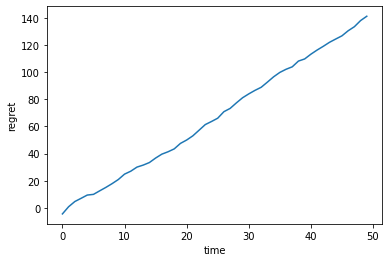

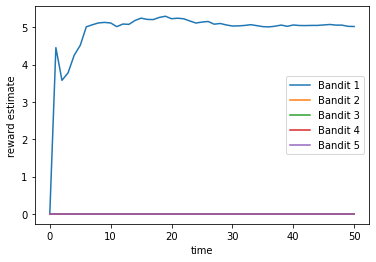

In [4]:
N_TRIALS = 50

sum_reward = 0
rewards = np.ndarray((N_TRIALS +1, len(testbed)))
regret = np.ndarray((N_TRIALS,))

estimated_rewards = [bandit.sample() for bandit in testbed]
rewards[0, :] = estimated_rewards
for n in range(N_TRIALS):
    bandit = testbed[np.argmax(estimated_rewards)]
    R = bandit.pull()
    sum_reward += R
    bandit.update(R)
    estimated_rewards = [bandit.sample() for bandit in testbed]
    rewards[n + 1, :] = estimated_rewards
    regret[n] = n * max(mean_rewards) - sum_reward

plt.figure()
plt.plot(regret)
plt.xlabel("time")
plt.ylabel("regret")
plt.show()

plt.figure()
for b in range(rewards.shape[1]):
    plt.plot(rewards[:, b], label=f'Bandit {b+1}')
plt.legend()
plt.xlabel("time")
plt.ylabel("reward estimate")
plt.show()

## Optimistic greedy algorithm

In an optimistic greedy algorithm we set the initial reward of all bandits to a high value.

This ensures that each bandit is at least sampled once. However, it is unclear what a high enough "optimistic" value is.

In [5]:
from bandit import Bandit


class OptimisticBandit(Bandit):
    """
    class for an optimistic bandit
    """
    def initialize(self, Q):
        self.Q = Q  # estimate of reward

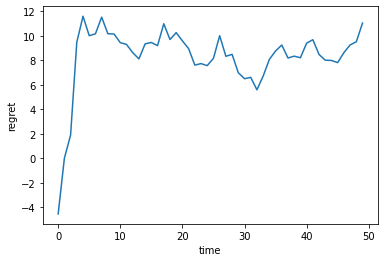

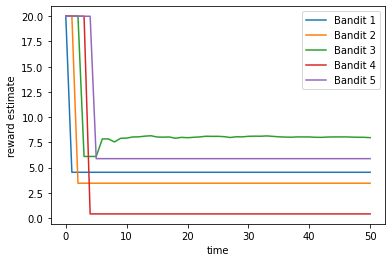

In [6]:
mean_rewards = [5, 4, 8, 3, 7]
testbed = [OptimisticBandit(mr, Q=20) for mr in mean_rewards]

N_TRIALS = 50

sum_reward = 0
rewards = np.ndarray((N_TRIALS +1, len(testbed)))
regret = np.ndarray((N_TRIALS,))

estimated_rewards = [bandit.sample() for bandit in testbed]
rewards[0, :] = estimated_rewards
for n in range(N_TRIALS):
    bandit = testbed[np.argmax(estimated_rewards)]
    R = bandit.pull()
    sum_reward += R
    bandit.update(R)
    estimated_rewards = [bandit.sample() for bandit in testbed]
    rewards[n + 1, :] = estimated_rewards
    regret[n] = n * max(mean_rewards) - sum_reward

plt.figure()
plt.plot(regret)
plt.xlabel("time")
plt.ylabel("regret")
plt.show()

plt.figure()
for b in range(rewards.shape[1]):
    plt.plot(rewards[:, b], label=f'Bandit {b+1}')
plt.legend()
plt.xlabel("time")
plt.ylabel("reward estimate")
plt.show()

## The $\epsilon$-greedy Algorithm

In the $\epsilon$-greedy algorithm, we randomly choose a bandit with probability $\epsilon$ and choose greedily otherwise. 

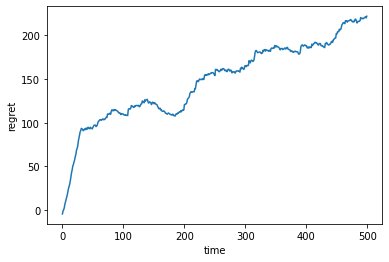

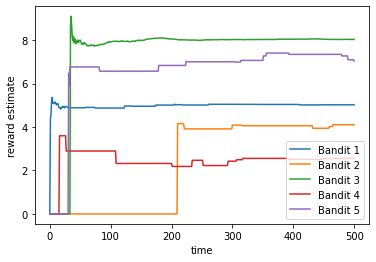

In [7]:
from bandit import Bandit
mean_rewards = [5, 4, 8, 3, 7]
testbed = [Bandit(mr) for mr in mean_rewards]

EPSILON = 0.1
N_TRIALS = 500

sum_reward = 0
rewards = np.ndarray((N_TRIALS +1, len(testbed)))
regret = np.ndarray((N_TRIALS,))

estimated_rewards = [bandit.sample() for bandit in testbed]
rewards[0, :] = estimated_rewards
for n in range(N_TRIALS):
    if np.random.random() < EPSILON:
        bandit = testbed[int(np.random.random() * len(testbed))]
    else:
        bandit = testbed[np.argmax(estimated_rewards)]
    R = bandit.pull()
    sum_reward += R
    bandit.update(R)
    estimated_rewards = [bandit.sample() for bandit in testbed]
    rewards[n + 1, :] = estimated_rewards
    regret[n] = n * max(mean_rewards) - sum_reward

plt.figure()
plt.plot(regret)
plt.xlabel("time")
plt.ylabel("regret")
plt.show()

plt.figure()
for b in range(rewards.shape[1]):
    plt.plot(rewards[:, b], label=f'Bandit {b+1}')
plt.legend()
plt.xlabel("time")
plt.ylabel("reward estimate")
plt.show()

## The Upper Confidence Bound (UCB) Algorithm

While $\epsilon$-greedy explores by randomly choosing actions with a constant rate, the UCB algorithm balances exploration and exploitation in a more advanced manner.

Here, the actions are chosen based on the reward estimate plus its uncertainty:
$
A_t = \text{arg max}_a \left( Q_t(a) + c \sqrt{\frac{\log(t)}{N_t(a)}} \right)
$

* c is a hyperparameter that controls exploration
* If an action is not chosen often, $N_t(a)$ is small, making the uncertainty large.
* As there is a $\log(t)$ in the numerator, the uncertainty is increasing slowly when action is not chosen
* But as $N_t(a)$ in the denominator is linear, it is decreasing rapidly, when chosen
* $\log(n)/n$ goes to zero for $n\rightarrow \infty$, so eventually, there will be exploitation only (unlike $\epsilon$-greedy).

In [8]:
from bandit import Bandit


class UCBBandit(Bandit):
    """
    class for an Upper Confidence Bound Algorithm bandit
    """
    def uncertainty(self, t, c=2.0):
        if t==0 or self.n==0: return 1e12
        return c * (np.sqrt(np.log(t) / self.n))

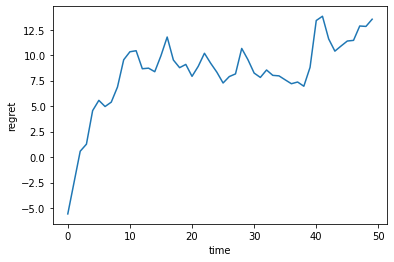

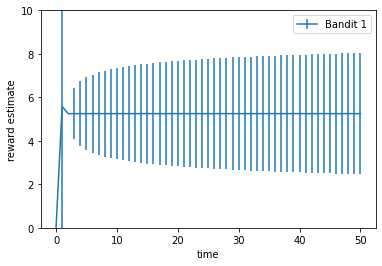

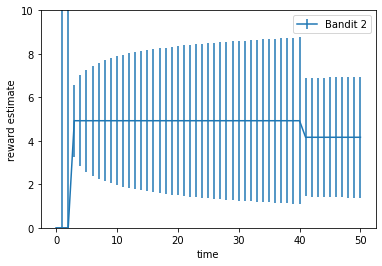

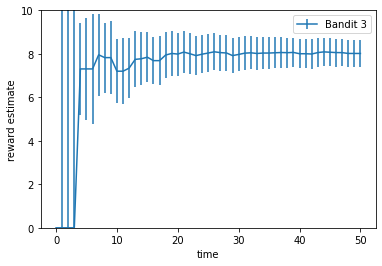

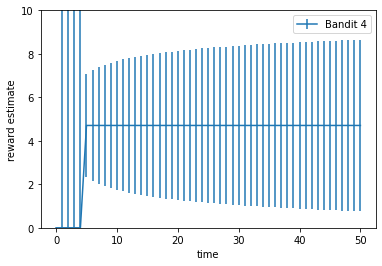

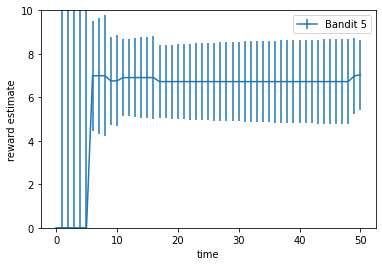

In [9]:
mean_rewards = [5, 4, 8, 3, 7]
testbed = [UCBBandit(mr) for mr in mean_rewards]

N_TRIALS = 50

sum_reward = 0
rewards = np.ndarray((N_TRIALS +1, len(testbed)))
uncertainties = np.ndarray((N_TRIALS +1, len(testbed)))
regret = np.ndarray((N_TRIALS,))

estimated_rewards = [bandit.sample() for bandit in testbed]
estimated_uncertainties = [bandit.uncertainty(t=0) for bandit in testbed]
rewards[0, :] = estimated_rewards
for t in range(N_TRIALS):
    bandit = testbed[np.argmax([r+u for r, u in zip(estimated_rewards, estimated_uncertainties)])]
    R = bandit.pull()
    sum_reward += R
    bandit.update(R)
    estimated_rewards = [bandit.sample() for bandit in testbed]
    estimated_uncertainties = [bandit.uncertainty(t=t) for bandit in testbed]
    rewards[t + 1, :] = estimated_rewards
    uncertainties[t + 1, :] = estimated_uncertainties
    regret[t] = t * max(mean_rewards) - sum_reward

plt.figure()
plt.plot(regret)
plt.xlabel("time")
plt.ylabel("regret")
plt.show()

for b in range(rewards.shape[1]):
    plt.figure()
    plt.errorbar(x=range(N_TRIALS+1), y=rewards[:, b], yerr=uncertainties[:, b], label=f'Bandit {b+1}')
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("reward estimate")
    plt.ylim(0, 10)
    plt.show()